In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
import matplotlib.pyplot as plt
from PIL import Image
from transformers import CLIPProcessor, CLIPModel, CLIPTokenizer
import wandb  # Add this import

/root/ImageCaption/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

# Load the dataset
dataset = load_dataset("nlphuji/flickr30k", split="test[:10000]")

# split into train and test sets
train_test = dataset.train_test_split(test_size=0.2)
train_dataset = train_test['train']
test_dataset = train_test['test']

# Inspect the first example
example = train_dataset[0]
print(example.keys())


dict_keys(['image', 'caption', 'sentids', 'split', 'img_id', 'filename'])


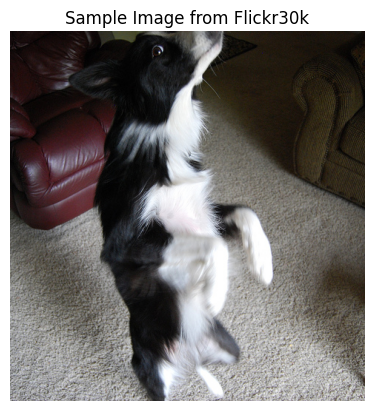

Captions:
1: A black and white dog standing on its hind legs on carpeting in front of a chair.
2: Black and white dog in living room standing on hind legs.
3: A black and white dog stands on its hind legs.
4: Closeup of a dog standing on its hind legs
5: A boy jumps.


In [3]:

# Display the image
plt.imshow(example['image'])
plt.axis('off')
plt.title("Sample Image from Flickr30k")
plt.show()

# Print the captions
print("Captions:")
for idx, caption in enumerate(example['caption']):
    print(f"{idx + 1}: {caption}")


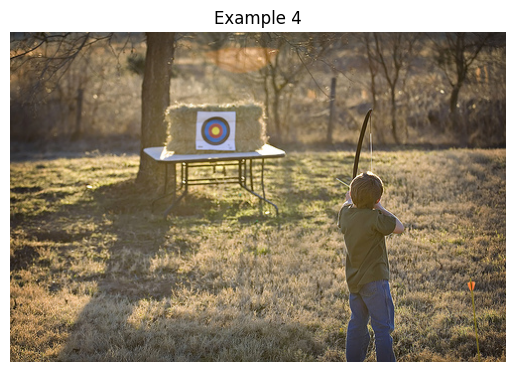

Captions for Example 4:
1: A boy taking aim at a target on a bale of hay with his bow and arrow.
2: Boy wearing jeans aiming bow and arrow toward target on a hay bale.
3: A boy is firing a gun at a bullseye attached to a hay barrel.
4: A young archer aims his bow at a haystack target.
5: A boy is aiming a bow and arrow at a target.
--------------------------------------------------


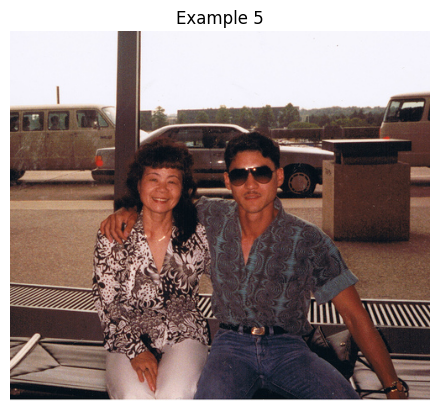

Captions for Example 5:
1: Two asian or spanish people, a woman and a man, sitting together in front of a glass window as cars pass.
2: A man in sunglasses puts his arm around a woman in a black and white blouse.
3: A man in sunglasses puts his arm around a woman.
4: A man and woman pose in front of some traffic.
5: An Asian couple sitting on the bench.
--------------------------------------------------


In [4]:
# Display the first 5 images with their captions
for i in range(3,5):
    example = train_dataset[i]

    # Show image
    plt.imshow(example['image'])
    plt.axis('off')
    plt.title(f"Example {i+1}")
    plt.show()

    # Show all captions
    print(f"Captions for Example {i+1}:")
    for j, caption in enumerate(example['caption']):
        print(f"{j + 1}: {caption}")
    print("-" * 50)


In [5]:
from datasets import load_dataset
from transformers import CLIPProcessor
from torch.utils.data import DataLoader
import torch

# Initialize the processor (handles both images and text)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Define the function to preprocess images and captions
def preprocess_function(samples):
    # Get the first caption for each image
    captions = [caption[0] if isinstance(caption, list) else caption for caption in samples['caption']]
    
    # Process the images and tokenize the captions
    inputs = processor(
        text=captions,
        images=samples['image'],
        padding=True,
        truncation=True,
        max_length=20,
        return_tensors="pt")
    
    # Return the tokenized captions, attention masks, and processed images (already tensors)
    return {
        'input_ids': inputs['input_ids'],
        'attention_mask': inputs['attention_mask'],
        'pixel_values': inputs['pixel_values'],  # The resized, normalized image tensors
    }

# Apply the preprocessing function to the train and test datasets
train_dataset = train_dataset.map(preprocess_function, batched=True)
test_dataset = test_dataset.map(preprocess_function, batched=True)

# Define the collate function
def collate_fn(batch):
    input_ids = torch.stack([torch.tensor(item['input_ids'], dtype=torch.long) for item in batch])
    attention_mask = torch.stack([torch.tensor(item['attention_mask'], dtype=torch.long) for item in batch])
    pixel_values = torch.stack([torch.tensor(item['pixel_values']) for item in batch])
    return {
        'input_ids': input_ids,
        'attention_mask': attention_mask,
        'pixel_values': pixel_values
    }


# Create the DataLoader for both train and test datasets
train_dataloader = DataLoader(train_dataset, batch_size=32, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=32, collate_fn=collate_fn)

# Optional: Print the first batch from the dataloader to ensure everything is correct
for batch in train_dataloader:
    print(batch)
    break  # Only print the first batch


# Save the processed datasets to disk
train_dataset.save_to_disk("train_dataset")
test_dataset.save_to_disk("test_dataset")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Map: 100%|██████████| 2000/2000 [00:23<00:00, 83.57 examples/s]


{'input_ids': tensor([[49406,   320,  1449,   537,  1579,  1929,  2862,   525,   902, 23293,
          7072,   525,   811,   661,   694,   530,  2184,   539,   320, 49407],
        [49406,   320,  2866,  1929,   593,   902,  2184, 16714,  1007,   518,
          2461,   525,   320, 44140,  7744,  2252,   736,   537,  5496, 49407],
        [49406,   320, 28959, 14069,  1876,   530,  1538,  9680,  6437,   530,
           525,   320,  6632, 10459,   530,   320, 12745,  1452,   269, 49407],
        [49406,   320,  1876,  2019, 11255,   536,   320,  5400,   525,   320,
         18873,   539, 11367,   593,   787,  4040,   537, 11149,   269, 49407],
        [49406,  1237,  7128,   541,  6013,  1047,   267,   320,  2308,   537,
           320,   786,   267,  4919,  1952,   530,  2184,   539,   320, 49407],
        [49406, 10237,   593, 13657,  9812,   631,  4919,   525,   911,  8809,
           537,  5050, 30506,   269, 49407, 49407, 49407, 49407, 49407, 49407],
        [49406,   550,   896,   

Saving the dataset (3/3 shards): 100%|██████████| 2000/2000 [00:00<00:00, 2652.96 examples/s]


In [6]:
from datasets import load_from_disk

# Load preprocessed datasets from disk
train_dataset = load_from_disk("train_dataset")
test_dataset = load_from_disk("test_dataset")


In [5]:
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, input_dim, emb_dim, num_heads):
        super().__init__()
        assert emb_dim % num_heads == 0
        self.emb_dim = emb_dim
        self.num_heads = num_heads
        self.head_dim = emb_dim // num_heads

        self.q_proj = nn.Linear(input_dim, emb_dim)
        self.k_proj = nn.Linear(input_dim, emb_dim)
        self.v_proj = nn.Linear(input_dim, emb_dim)
        self.out_proj = nn.Linear(emb_dim, input_dim)  # or emb_dim depending on your design

    def forward(self, x, mask=None):
        B, N, _ = x.shape
        q = self.q_proj(x).reshape(B, N, self.num_heads, self.head_dim).transpose(1, 2)
        k = self.k_proj(x).reshape(B, N, self.num_heads, self.head_dim).transpose(1, 2)
        v = self.v_proj(x).reshape(B, N, self.num_heads, self.head_dim).transpose(1, 2)

        attn_scores = (q @ k.transpose(-2, -1)) / (self.head_dim ** 0.5)
        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask == 0, float('-inf'))
        attn = torch.softmax(attn_scores, dim=-1)
        out = (attn @ v).transpose(1, 2).reshape(B, N, self.emb_dim)
        return self.out_proj(out)
    

In [6]:
class FeedForward(nn.Module):
    def __init__(self, emb_dim, ff_hidden_dim):
        super().__init__()
        self.MLP = nn.Sequential(
            nn.Linear(emb_dim, ff_hidden_dim),
            nn.ReLU(),
            nn.Linear(ff_hidden_dim, emb_dim)
        )
    def forward(self, x):
        return self.MLP(x)
    


In [7]:

class TransformerDecoderBlock(nn.Module):
    def __init__(self, emb_dim, num_heads, ff_hidden_dim):
        super().__init__()
        self.self_attn = MultiHeadSelfAttention(emb_dim, emb_dim, num_heads)
        self.ff = FeedForward(emb_dim, ff_hidden_dim)

        self.norm1 = nn.LayerNorm(emb_dim)
        self.norm2 = nn.LayerNorm(emb_dim)

    def forward(self, x, mask=None):
        x = x + self.self_attn(self.norm1(x), mask=mask)   # Self-attention with residual
        x = x + self.ff(self.norm2(x))                     # Feedforward with residual
        return x
    

In [8]:
class ImageCaptionModel(nn.Module):
    def __init__(self, num_decoder_layers, decoder_layer, emb_dim, num_heads, ff_hidden_dim, clip_model_name="openai/clip-vit-base-patch32"):
        super().__init__()

        self.clip_model = CLIPModel.from_pretrained(clip_model_name) # importing the CLIP model
        self.image_encoder = self.clip_model.vision_model # extracting the image encoder part of the CLIP model
        self.processor = CLIPProcessor.from_pretrained(clip_model_name) # extracting the image preprocessor from the CLIP model

        # Freeze CLIP image encoder parameters
        for img_param in self.image_encoder.parameters():
            img_param.requires_grad = False

        # DOUBLE CHECK THIS 
        self.text_embedding = self.clip_model.text_model.embeddings.token_embedding  # Text embedding layer
        self.text_proj = nn.Linear(512, 768)  # Project text to match image embedding dimension
        # Freeze CLIP text embedding parameters
        for text_param in self.text_embedding.parameters():
            text_param.requires_grad = False

        # Load tokenizer for the CLIP model (including BOS/EOS tokens)
        self.tokenizer = CLIPTokenizer.from_pretrained(clip_model_name)

        # REVIEW THE DIMENSIONS HERE
        self.pos_embed = nn.Parameter(torch.randn(1, 71, emb_dim))  # 71 is max total sequence length (image + text)

# Update decoder layers to use input_dim=emb_dim (1048)
        self.decoder = nn.ModuleList([
            decoder_layer(emb_dim, num_heads, ff_hidden_dim) for _ in range(num_decoder_layers)
        ])

        # Learnable output projection (to vocab size)
        self.output_layer = nn.Linear(emb_dim, self.tokenizer.vocab_size)

        # Add a projection layer to match the decoder's expected input dimension
        self.combined_proj = nn.Linear(768, emb_dim)  # Project combined tensor to emb_dim (1048)

    def generate_causal_mask(self, attention_mask, image_len, device):
        """
        attention_mask: (B, T_text), with 1s for real tokens, 0s for padding/post-EOS
        Returns:
            mask: (B, 1, T_total, T_total)
        """
        B, T_text = attention_mask.size()
        T_total = image_len + T_text

        # Base causal mask for text
        causal_mask = torch.tril(torch.ones(T_text, T_text, device=device))  # (T_text, T_text)

        # Apply attention mask: only allow attention to non-masked tokens
        attn_mask = attention_mask.unsqueeze(1).float()  # (B, 1, T_text)
        text_mask = causal_mask.unsqueeze(0) * attn_mask  # (B, T_text, T_text)

        # Expand to full attention mask
        full_mask = torch.ones(B, T_total, T_total, device=device)

        # Image-image and image-text remain fully visible
        full_mask[:, image_len:, image_len:] = text_mask

        return full_mask.unsqueeze(1)  # (B, 1, T_total, T_total)

        
    """    
    def generate_causal_mask(self, attention_mask, seq_len, image_len, device):
        # Only apply causal mask to the text portion
        mask = torch.ones(seq_len, seq_len, device=device)
        mask = torch.tril(mask)  # Causal lower-triangular mask
        full_mask = torch.ones(seq_len + image_len, seq_len + image_len, device=device)

        # Keep image-image and image-text fully visible (no mask)
        full_mask[image_len:, image_len:] = mask  # Causal mask for text
        return full_mask.unsqueeze(0).unsqueeze(1)  # Shape: (1, 1, total_len, total_len)
    """
    

    def decode(self, images, text_input_ids, attention_mask):
        # Encode image
        image_outputs = self.image_encoder(pixel_values=images).last_hidden_state  # (B, I, D)
        B, I, D = image_outputs.shape

        # Embed text
        text_embeds = self.text_embedding(text_input_ids)  # (B, T, D)
        text_embeds = self.text_proj(text_embeds)  # (B, T, D)

        # Concat [image | text] tokens
        combined = torch.cat([image_outputs, text_embeds], dim=1)  # (B, I+T, D)

        # Project combined tensor to match decoder's expected input dimension
        combined = self.combined_proj(combined)  # (B, I+T, emb_dim)

        # Generate mask using attention mask
        mask = self.generate_causal_mask(attention_mask=attention_mask, image_len=I, device=images.device)

        pos = self.pos_embed[:, :combined.size(1), :]
        x = combined + pos
        
        for layer in self.decoder:
            x = layer(x, mask=mask)

        # Project only the text part
        output_logits = self.output_layer(x[:, I:, :])  # (B, T, vocab_size)
        return output_logits
    

    @torch.no_grad()
    def generate(self, image, max_length=18, temperature=0.7):
        """
        image: preprocessed image tensor of shape (1, 3, H, W)
        Returns: list of generated token IDs
        """
        self.eval()

        generated = [self.tokenizer.bos_token_id]  # Start with BOS token

        for _ in range(max_length):
            # Create tensor from current tokens
            input_ids = torch.tensor([generated], device=image.device)
            attention_mask = torch.ones_like(input_ids, device=image.device)  # Mask for current tokens

            # Use decode function
            logits = self.decode(image, input_ids, attention_mask)  # (1, T, vocab_size)
            next_token_logits = logits[:, -1, :]  # (1, vocab_size)

            # Apply temperature scaling
            scaled_logits = next_token_logits / temperature
            probs = torch.softmax(scaled_logits, dim=-1)

            # Sample from the probability distribution
            next_token = torch.multinomial(probs, num_samples=1).item()
            generated.append(next_token)

            if next_token == self.tokenizer.eos_token_id:  # Use EOS token for stopping condition
                break

        return generated[1:]  # Drop BOS token


In [ ]:
import torch
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss
from tqdm import tqdm

import wandb  # Add this import

def train_model(model, train_dataloader, optimizer, criterion, device, num_epochs=5):
    """
    Train the ImageCaptionModel and log metrics to wandb.
    """
    # Initialize wandb
    wandb.init(project="image-captioning", name="training-run", entity="emilengdahl",config={
        "num_epochs": num_epochs,
        "batch_size": train_dataloader.batch_size,
        "learning_rate": optimizer.param_groups[0]['lr']
    }, reinit=True)

    print(f"[INFO] Starting training on {device}")
    model.train()
    model.to(device)
    
    for epoch in range(num_epochs):
        print(f"\n[INFO] Epoch {epoch + 1}/{num_epochs} begins")
        epoch_loss = 0.0
        progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch + 1}/{num_epochs}")
        
        for i, batch in enumerate(progress_bar):
            # Move batch data to the device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            pixel_values = batch['pixel_values'].to(device)

            # Forward pass
            optimizer.zero_grad()
            logits = model.decode(pixel_values, input_ids[:, :-1], attention_mask[:, :-1])  # Teacher forcing
            
            # Compute loss
            loss = criterion(logits.reshape(-1, logits.size(-1)), input_ids[:, 1:].reshape(-1))
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            progress_bar.set_postfix(loss=loss.item())

            # Log metrics to wandb
            wandb.log({"batch_loss": loss.item()})

        avg_epoch_loss = epoch_loss / len(train_dataloader)
        print(f"[INFO] Epoch {epoch + 1} completed. Average Loss: {avg_epoch_loss:.4f}")

        # Log epoch loss to wandb
        wandb.log({"epoch": epoch + 1, "epoch_loss": avg_epoch_loss})

    # Finish wandb run
    wandb.finish()


@torch.no_grad()
def evaluate_model(model, test_dataloader, criterion, device):
    """
    Evaluate the ImageCaptionModel.
    """
    print(f"\n[INFO] Starting evaluation on {device}")
    model.eval()
    model.to(device)
    
    total_loss = 0.0
    progress_bar = tqdm(test_dataloader, desc="Evaluating")
    
    for i, batch in enumerate(progress_bar):
        # Move batch data to the device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        pixel_values = batch['pixel_values'].to(device)

        if i == 0:
            print(f"[DEBUG] Evaluation input_ids shape: {input_ids.shape}")
        
        # Forward pass
        logits = model.decode(pixel_values, input_ids[:, :-1], attention_mask[:, :-1])
        
        # Compute loss
        loss = criterion(logits.reshape(-1, logits.size(-1)), input_ids[:, 1:].reshape(-1))
        total_loss += loss.item()

    avg_loss = total_loss / len(test_dataloader)
    print(f"[INFO] Evaluation completed. Average Loss: {avg_loss:.4f}")
    return avg_loss


# Example usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[INFO] Using device: {device}")

model = ImageCaptionModel(
    num_decoder_layers=4,
    decoder_layer=TransformerDecoderBlock,
    emb_dim=1048,
    num_heads=8,
    ff_hidden_dim=768
)

optimizer = AdamW(model.parameters(), lr=5e-5)
criterion = CrossEntropyLoss(ignore_index=model.tokenizer.pad_token_id)  # Replace with tokenizer.pad_token_id if known

train_model(model, train_dataloader, optimizer, criterion, device, num_epochs=16)
evaluate_model(model, test_dataloader, criterion, device)


[INFO] Using device: cuda


[INFO] Using device: cuda


[INFO] Using device: cuda


[INFO] Using device: cuda


[INFO] Using device: cuda


[INFO] Starting training on cuda

[INFO] Epoch 1/16 begins


Epoch 1/16: 100%|██████████| 250/250 [15:19<00:00,  3.68s/it, loss=5.53]


[INFO] Using device: cuda


[INFO] Starting training on cuda

[INFO] Epoch 1/16 begins


Epoch 1/16: 100%|██████████| 250/250 [15:19<00:00,  3.68s/it, loss=5.53]


[INFO] Epoch 1 completed. Average Loss: 5.9791

[INFO] Epoch 2/16 begins


Epoch 2/16: 100%|██████████| 250/250 [15:20<00:00,  3.68s/it, loss=5.11]


[INFO] Using device: cuda


[INFO] Starting training on cuda

[INFO] Epoch 1/16 begins


Epoch 1/16: 100%|██████████| 250/250 [15:19<00:00,  3.68s/it, loss=5.53]


[INFO] Epoch 1 completed. Average Loss: 5.9791

[INFO] Epoch 2/16 begins


Epoch 2/16: 100%|██████████| 250/250 [15:20<00:00,  3.68s/it, loss=5.11]


[INFO] Epoch 2 completed. Average Loss: 5.2233

[INFO] Epoch 3/16 begins


Epoch 3/16: 100%|██████████| 250/250 [15:22<00:00,  3.69s/it, loss=4.69]


[INFO] Using device: cuda


[INFO] Starting training on cuda

[INFO] Epoch 1/16 begins


Epoch 1/16: 100%|██████████| 250/250 [15:19<00:00,  3.68s/it, loss=5.53]


[INFO] Epoch 1 completed. Average Loss: 5.9791

[INFO] Epoch 2/16 begins


Epoch 2/16: 100%|██████████| 250/250 [15:20<00:00,  3.68s/it, loss=5.11]


[INFO] Epoch 2 completed. Average Loss: 5.2233

[INFO] Epoch 3/16 begins


Epoch 3/16: 100%|██████████| 250/250 [15:22<00:00,  3.69s/it, loss=4.69]


[INFO] Epoch 3 completed. Average Loss: 4.7670

[INFO] Epoch 4/16 begins


Epoch 4/16: 100%|██████████| 250/250 [15:23<00:00,  3.69s/it, loss=4.34]


[INFO] Using device: cuda


[INFO] Starting training on cuda

[INFO] Epoch 1/16 begins


Epoch 1/16: 100%|██████████| 250/250 [15:19<00:00,  3.68s/it, loss=5.53]


[INFO] Epoch 1 completed. Average Loss: 5.9791

[INFO] Epoch 2/16 begins


Epoch 2/16: 100%|██████████| 250/250 [15:20<00:00,  3.68s/it, loss=5.11]


[INFO] Epoch 2 completed. Average Loss: 5.2233

[INFO] Epoch 3/16 begins


Epoch 3/16: 100%|██████████| 250/250 [15:22<00:00,  3.69s/it, loss=4.69]


[INFO] Epoch 3 completed. Average Loss: 4.7670

[INFO] Epoch 4/16 begins


Epoch 4/16: 100%|██████████| 250/250 [15:23<00:00,  3.69s/it, loss=4.34]


[INFO] Epoch 4 completed. Average Loss: 4.4036

[INFO] Epoch 5/16 begins


Epoch 5/16: 100%|██████████| 250/250 [15:23<00:00,  3.70s/it, loss=4.02]


[INFO] Using device: cuda


[INFO] Starting training on cuda

[INFO] Epoch 1/16 begins


Epoch 1/16: 100%|██████████| 250/250 [15:19<00:00,  3.68s/it, loss=5.53]


[INFO] Epoch 1 completed. Average Loss: 5.9791

[INFO] Epoch 2/16 begins


Epoch 2/16: 100%|██████████| 250/250 [15:20<00:00,  3.68s/it, loss=5.11]


[INFO] Epoch 2 completed. Average Loss: 5.2233

[INFO] Epoch 3/16 begins


Epoch 3/16: 100%|██████████| 250/250 [15:22<00:00,  3.69s/it, loss=4.69]


[INFO] Epoch 3 completed. Average Loss: 4.7670

[INFO] Epoch 4/16 begins


Epoch 4/16: 100%|██████████| 250/250 [15:23<00:00,  3.69s/it, loss=4.34]


[INFO] Epoch 4 completed. Average Loss: 4.4036

[INFO] Epoch 5/16 begins


Epoch 5/16: 100%|██████████| 250/250 [15:23<00:00,  3.70s/it, loss=4.02]


[INFO] Epoch 5 completed. Average Loss: 4.0931

[INFO] Epoch 6/16 begins


Epoch 6/16: 100%|██████████| 250/250 [15:23<00:00,  3.69s/it, loss=2.99]


[INFO] Using device: cuda


[INFO] Starting training on cuda

[INFO] Epoch 1/16 begins


Epoch 1/16: 100%|██████████| 250/250 [15:19<00:00,  3.68s/it, loss=5.53]


[INFO] Epoch 1 completed. Average Loss: 5.9791

[INFO] Epoch 2/16 begins


Epoch 2/16: 100%|██████████| 250/250 [15:20<00:00,  3.68s/it, loss=5.11]


[INFO] Epoch 2 completed. Average Loss: 5.2233

[INFO] Epoch 3/16 begins


Epoch 3/16: 100%|██████████| 250/250 [15:22<00:00,  3.69s/it, loss=4.69]


[INFO] Epoch 3 completed. Average Loss: 4.7670

[INFO] Epoch 4/16 begins


Epoch 4/16: 100%|██████████| 250/250 [15:23<00:00,  3.69s/it, loss=4.34]


[INFO] Epoch 4 completed. Average Loss: 4.4036

[INFO] Epoch 5/16 begins


Epoch 5/16: 100%|██████████| 250/250 [15:23<00:00,  3.70s/it, loss=4.02]


[INFO] Epoch 5 completed. Average Loss: 4.0931

[INFO] Epoch 6/16 begins


Epoch 6/16: 100%|██████████| 250/250 [15:23<00:00,  3.69s/it, loss=2.99]


[INFO] Epoch 6 completed. Average Loss: 3.4496

[INFO] Epoch 7/16 begins


Epoch 7/16: 100%|██████████| 250/250 [15:25<00:00,  3.70s/it, loss=2.03]


[INFO] Using device: cuda


[INFO] Starting training on cuda

[INFO] Epoch 1/16 begins


Epoch 1/16: 100%|██████████| 250/250 [15:19<00:00,  3.68s/it, loss=5.53]


[INFO] Epoch 1 completed. Average Loss: 5.9791

[INFO] Epoch 2/16 begins


Epoch 2/16: 100%|██████████| 250/250 [15:20<00:00,  3.68s/it, loss=5.11]


[INFO] Epoch 2 completed. Average Loss: 5.2233

[INFO] Epoch 3/16 begins


Epoch 3/16: 100%|██████████| 250/250 [15:22<00:00,  3.69s/it, loss=4.69]


[INFO] Epoch 3 completed. Average Loss: 4.7670

[INFO] Epoch 4/16 begins


Epoch 4/16: 100%|██████████| 250/250 [15:23<00:00,  3.69s/it, loss=4.34]


[INFO] Epoch 4 completed. Average Loss: 4.4036

[INFO] Epoch 5/16 begins


Epoch 5/16: 100%|██████████| 250/250 [15:23<00:00,  3.70s/it, loss=4.02]


[INFO] Epoch 5 completed. Average Loss: 4.0931

[INFO] Epoch 6/16 begins


Epoch 6/16: 100%|██████████| 250/250 [15:23<00:00,  3.69s/it, loss=2.99]


[INFO] Epoch 6 completed. Average Loss: 3.4496

[INFO] Epoch 7/16 begins


Epoch 7/16: 100%|██████████| 250/250 [15:25<00:00,  3.70s/it, loss=2.03]


[INFO] Epoch 7 completed. Average Loss: 2.4038

[INFO] Epoch 8/16 begins


Epoch 8/16: 100%|██████████| 250/250 [15:25<00:00,  3.70s/it, loss=1.48]


[INFO] Using device: cuda


[INFO] Starting training on cuda

[INFO] Epoch 1/16 begins


Epoch 1/16: 100%|██████████| 250/250 [15:19<00:00,  3.68s/it, loss=5.53]


[INFO] Epoch 1 completed. Average Loss: 5.9791

[INFO] Epoch 2/16 begins


Epoch 2/16: 100%|██████████| 250/250 [15:20<00:00,  3.68s/it, loss=5.11]


[INFO] Epoch 2 completed. Average Loss: 5.2233

[INFO] Epoch 3/16 begins


Epoch 3/16: 100%|██████████| 250/250 [15:22<00:00,  3.69s/it, loss=4.69]


[INFO] Epoch 3 completed. Average Loss: 4.7670

[INFO] Epoch 4/16 begins


Epoch 4/16: 100%|██████████| 250/250 [15:23<00:00,  3.69s/it, loss=4.34]


[INFO] Epoch 4 completed. Average Loss: 4.4036

[INFO] Epoch 5/16 begins


Epoch 5/16: 100%|██████████| 250/250 [15:23<00:00,  3.70s/it, loss=4.02]


[INFO] Epoch 5 completed. Average Loss: 4.0931

[INFO] Epoch 6/16 begins


Epoch 6/16: 100%|██████████| 250/250 [15:23<00:00,  3.69s/it, loss=2.99]


[INFO] Epoch 6 completed. Average Loss: 3.4496

[INFO] Epoch 7/16 begins


Epoch 7/16: 100%|██████████| 250/250 [15:25<00:00,  3.70s/it, loss=2.03]


[INFO] Epoch 7 completed. Average Loss: 2.4038

[INFO] Epoch 8/16 begins


Epoch 8/16: 100%|██████████| 250/250 [15:25<00:00,  3.70s/it, loss=1.48]


[INFO] Epoch 8 completed. Average Loss: 1.7000

[INFO] Epoch 9/16 begins


Epoch 9/16:  22%|██▏       | 55/250 [03:23<11:58,  3.69s/it, loss=1.41]

In [12]:
# view train_dataloader dimensions
for batch in train_dataloader:
    print(batch['input_ids'].shape)  # (B, T)
    print(batch['attention_mask'].shape)  # (B, T)
    print(batch['pixel_values'].shape)  # (B, 3, H, W)
    break  # Only print the first batch dimensions

torch.Size([32, 20])
torch.Size([32, 20])
torch.Size([32, 3, 224, 224])


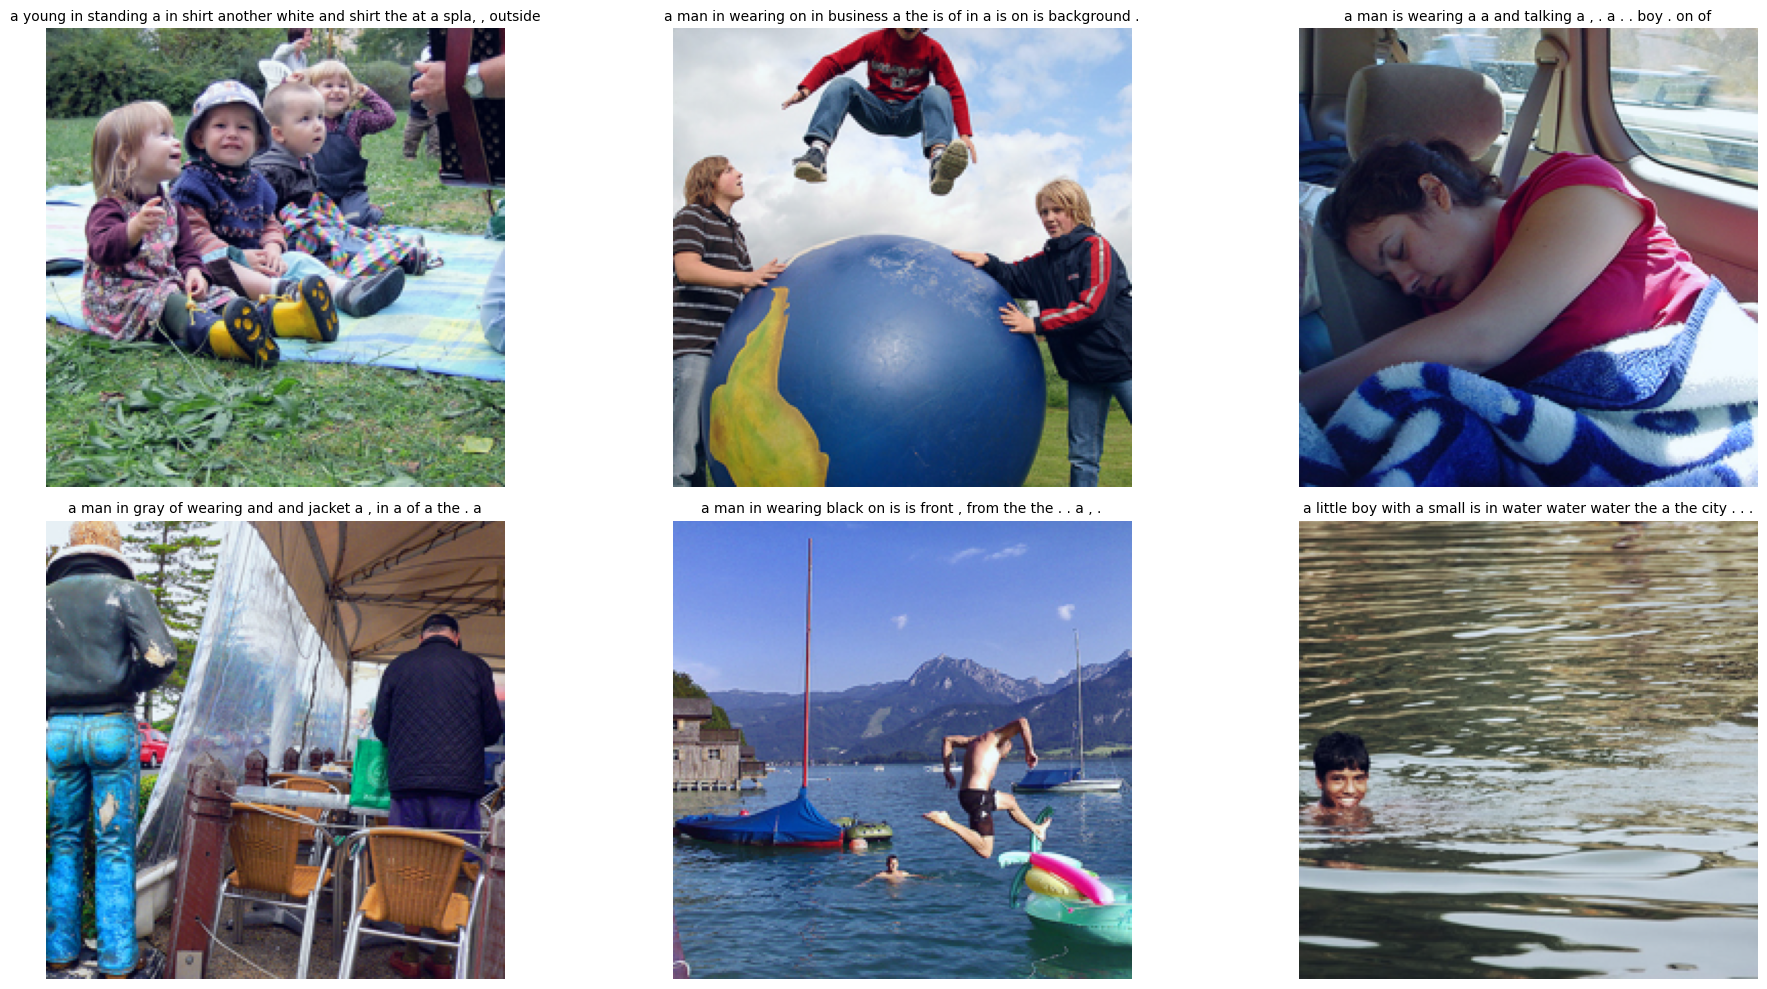

In [13]:
import matplotlib.pyplot as plt
import torch

# Set model to eval mode and move to device
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Helper to show a single image
def show_image(image_tensor, ax):
    img = image_tensor.permute(1, 2, 0).detach().cpu().numpy()
    img = (img - img.min()) / (img.max() - img.min())  # Normalize to [0, 1]
    ax.imshow(img)
    ax.axis('off')

# Load a batch from the test dataloader
batch = next(iter(test_dataloader))
images = batch['pixel_values'][:6]  # First 6 images in batch
images = images.to(device)

# Generate captions
fig, axs = plt.subplots(2, 3, figsize=(20, 10))
for i in range(6):  # Now looping over 6 images
    img = images[i].unsqueeze(0)  # Shape: (1, 3, 224, 224)

    # Generate caption
    with torch.no_grad():
        token_ids = model.generate(img)
        caption = model.tokenizer.decode(token_ids, skip_special_tokens=True)

    # Show image and caption
    ax = axs[i // 3, i % 3]  # Flatten 2D axes array indexing
    show_image(images[i], ax)
    ax.set_title(caption, fontsize=10)

plt.tight_layout()
plt.show()


In [15]:
import torch
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss
from tqdm import tqdm

import wandb  # Add this import


# Example usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[INFO] Using device: {device}")

model2 = ImageCaptionModel(
    num_decoder_layers=8,
    decoder_layer=TransformerDecoderBlock,
    emb_dim=768,
    num_heads=4,
    ff_hidden_dim=768
)

optimizer = AdamW(model2.parameters(), lr=5e-5)
criterion = CrossEntropyLoss(ignore_index=model2.tokenizer.pad_token_id)  # Replace with tokenizer.pad_token_id if known

train_model(model2, train_dataloader, optimizer, criterion, device, num_epochs=8)
evaluate_model(model2, test_dataloader, criterion, device)


[INFO] Using device: cuda


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


[INFO] Starting training on cuda

[INFO] Epoch 1/8 begins


Epoch 1/8: 100%|██████████| 250/250 [15:23<00:00,  3.69s/it, loss=5.52]


[INFO] Epoch 1 completed. Average Loss: 5.9825

[INFO] Epoch 2/8 begins


Epoch 2/8: 100%|██████████| 250/250 [15:18<00:00,  3.67s/it, loss=5.22]


[INFO] Epoch 2 completed. Average Loss: 5.2759

[INFO] Epoch 3/8 begins


Epoch 3/8: 100%|██████████| 250/250 [15:13<00:00,  3.65s/it, loss=4.82]


[INFO] Epoch 3 completed. Average Loss: 4.8991

[INFO] Epoch 4/8 begins


Epoch 4/8: 100%|██████████| 250/250 [15:10<00:00,  3.64s/it, loss=4.53]


[INFO] Epoch 4 completed. Average Loss: 4.5777

[INFO] Epoch 5/8 begins


Epoch 5/8: 100%|██████████| 250/250 [15:09<00:00,  3.64s/it, loss=4.25]


[INFO] Epoch 5 completed. Average Loss: 4.2835

[INFO] Epoch 6/8 begins


Epoch 6/8: 100%|██████████| 250/250 [15:08<00:00,  3.63s/it, loss=3.96]


[INFO] Epoch 6 completed. Average Loss: 3.9885

[INFO] Epoch 7/8 begins


Epoch 7/8: 100%|██████████| 250/250 [15:08<00:00,  3.63s/it, loss=3.62]


[INFO] Epoch 7 completed. Average Loss: 3.6301

[INFO] Epoch 8/8 begins


Epoch 8/8: 100%|██████████| 250/250 [15:08<00:00,  3.64s/it, loss=3.2] 

[INFO] Epoch 8 completed. Average Loss: 3.2100



[INFO] Starting evaluation on cuda


Evaluating:   2%|▏         | 1/63 [00:03<03:42,  3.59s/it]

[DEBUG] Evaluation input_ids shape: torch.Size([32, 20])


Evaluating: 100%|██████████| 63/63 [03:46<00:00,  3.59s/it]

[INFO] Evaluation completed. Average Loss: 3.8531


3.85309274234469

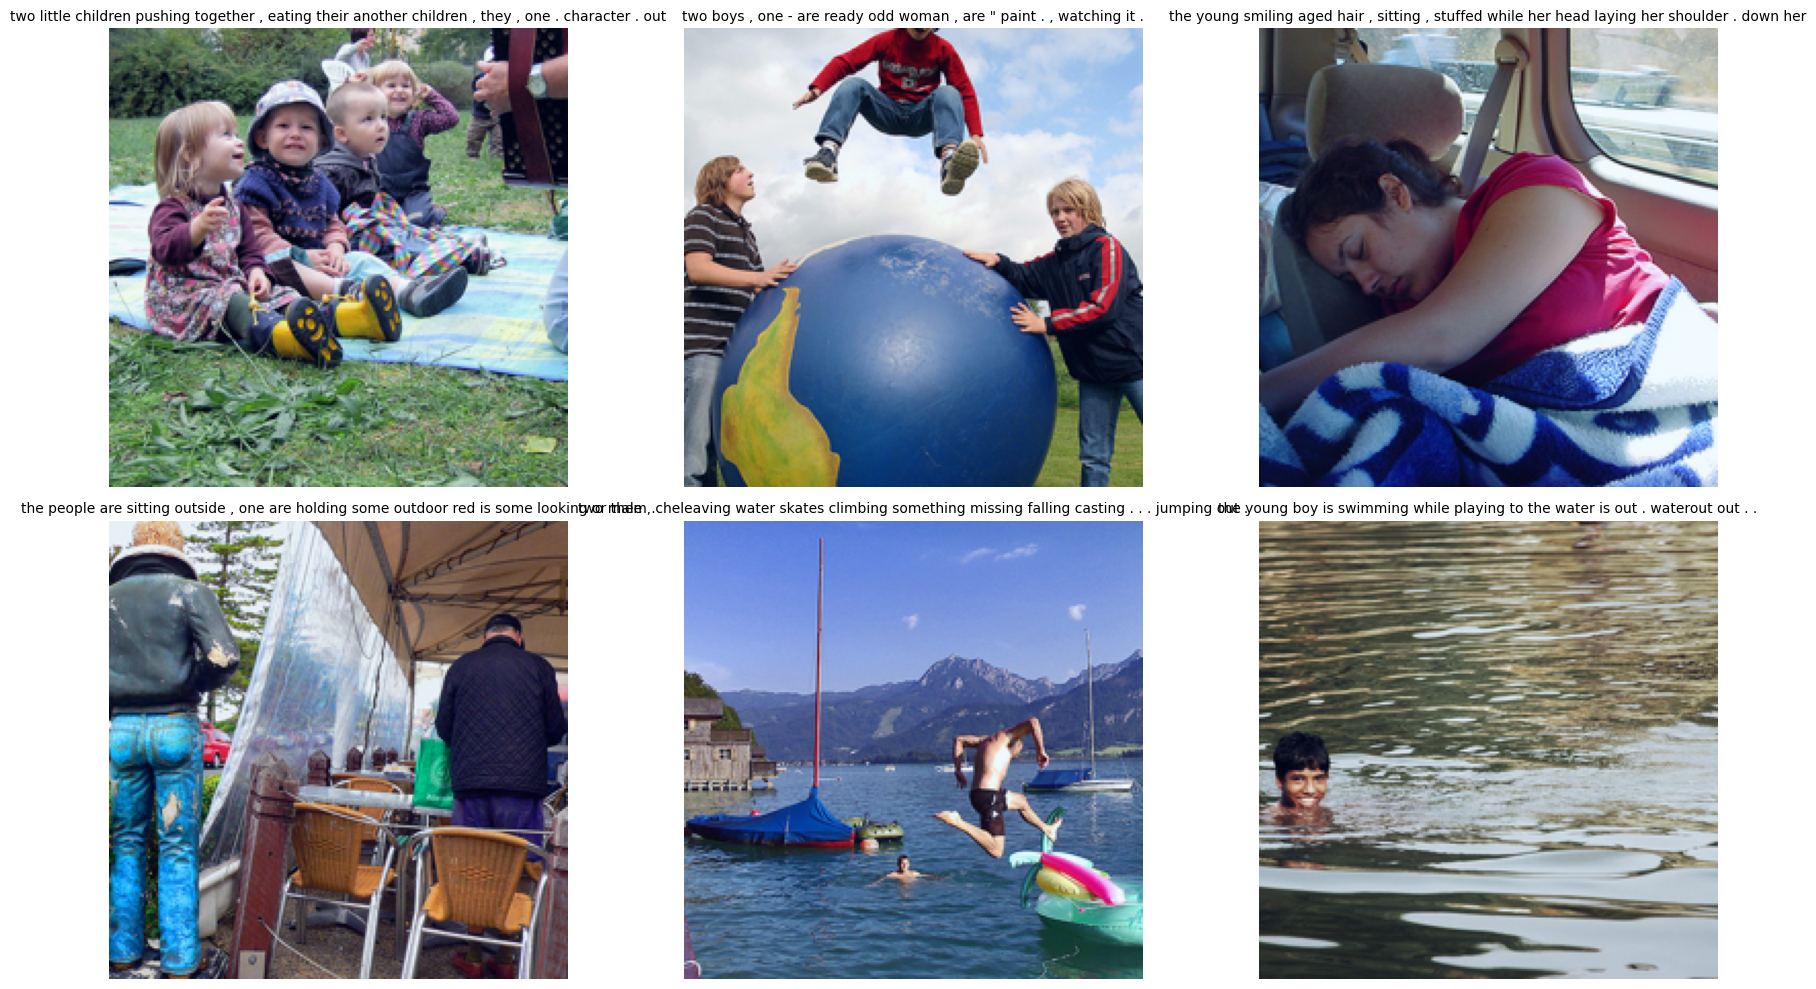

In [18]:
import matplotlib.pyplot as plt
import torch

# Set model to eval mode and move to device
model2.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model2.to(device)

# Helper to show a single image
def show_image(image_tensor, ax):
    img = image_tensor.permute(1, 2, 0).detach().cpu().numpy()
    img = (img - img.min()) / (img.max() - img.min())  # Normalize to [0, 1]
    ax.imshow(img)
    ax.axis('off')

# Load a batch from the test dataloader
batch = next(iter(test_dataloader))
images = batch['pixel_values'][:6]  # First 6 images in batch
images = images.to(device)

# Generate captions
fig, axs = plt.subplots(2, 3, figsize=(18, 10))
for i in range(6):  # Now looping over 6 images
    img = images[i].unsqueeze(0)  # Shape: (1, 3, 224, 224)

    # Generate caption
    with torch.no_grad():
        token_ids = model2.generate(img)
        caption = model2.tokenizer.decode(token_ids, skip_special_tokens=True)

    # Show image and caption
    ax = axs[i // 3, i % 3]  # Flatten 2D axes array indexing
    show_image(images[i], ax)
    ax.set_title(caption, fontsize=10)

plt.tight_layout()
plt.show()


In [9]:


# Load the model from the saved checkpoint
model = ImageCaptionModel(
    num_decoder_layers=4,
    decoder_layer=TransformerDecoderBlock,
    emb_dim=1048,
    num_heads=8,
    ff_hidden_dim=768
)

# Load the saved weights
checkpoint_path = "latest_model.pth"
model.load_state_dict(torch.load(checkpoint_path, map_location=torch.device('cpu')))

# Count the number of parameters in the model
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

num_params = count_parameters(model)
print(f"[INFO] The model has {num_params} trainable parameters.")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


[INFO] The model has 115680289 trainable parameters.
